In [1]:
# load h5s -> dataloader #
##########################

base_dir = "/mnt/bigdata/placenta-old/"
h5_subdir = "h5mini"

import lib
import torch
from pathlib import Path

base_dir = Path(base_dir)
h5folder = base_dir / Path(h5_subdir)
h5files = list(h5folder.glob("*.h5path"))
datasets = []
ds_fullsize = 0

for h5file in h5files:
    print(f"creating dataset from {str(h5file)} with TransformedPathmlTileSet")
    datasets.append(lib.TransformedPathmlTileSet(h5file))

full_ds = torch.utils.data.ConcatDataset(datasets)

dataloader = torch.utils.data.DataLoader(
    full_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True
)

2024-01-08 16:10:44.169794: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 16:10:44.304280: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 16:10:44.304319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 16:10:44.326485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 16:10:44.373793: I tensorflow/core/platform/cpu_feature_guar

creating dataset from /mnt/bigdata/placenta-old/h5mini/20230815_103309_b.h5path with TransformedPathmlTileSet


In [2]:
# load model #
##############

model_checkpoint_file = "/mnt/bigdata/placenta/training_checkpoints/orchid-ibex27.ckpt"

model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,
    verbose=True
)


checkpoint = torch.load(model_checkpoint_file)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(checkpoint["model_state_dict"])

Using cache found in /home/peet/.cache/torch/hub/moskomule_senet.pytorch_master


<All keys matched successfully>

In [3]:
# init tensorboard writer #
###########################
# from torch.utils.tensorboard import SummaryWriter
# # tensorboard --logdir /mnt/bigdata/placenta/tensorboard_data
# # firefox http://localhost:6006/
# session_name = model_checkpoint.split(".")[0][:-1]
# tensorboard_log_dir = base_dir / "tensorboard_data" / session_name

# writer = SummaryWriter(log_dir=tensorboard_log_dir, comment="inference")

# ...
# writer.add_figure("ROC/AUC fig", fig, global_step=None, close=True, walltime=None)   
# writer.add_graph(model, images)

In [4]:
# load wsi #
############

tile_size = 500
wsi_file = "/mnt/bigdata/placenta-old/h5mini/20230815_103309_b.tif"

import matplotlib.pyplot as plt
# from pathml.utils import plot_mask
from pathml.core import HESlide, Tile, types


pml_wsi = HESlide(
        wsi_file,
        backend="openslide",
        slide_type=types.HE,
    )

print("some details of ", pml_wsi.name)
print("shape: ", pml_wsi.shape)
print("level_count: ", pml_wsi.slide.level_count)
print("level_downsamples (from 0 index to n): ", pml_wsi.slide.slide.level_downsamples)
print("level_dimensions (h,w): ", pml_wsi.slide.slide.level_dimensions)
try:
    print("color profile: ", pml_wsi.slide.slide.color_profile.profile.profile_description)
except:
    print("no color profile information found")
print("rgb?: ", pml_wsi.slide_type.rgb)
print("masks: ", len(pml_wsi.masks))
print("tiles: ", len(pml_wsi.tiles))
print("labels: ", pml_wsi.labels)

some details of  20230815_103309_b.tif
shape:  (8861, 9462)
level_count:  1
level_downsamples (from 0 index to n):  (1.0,)
level_dimensions (h,w):  ((9462, 8861),)
no color profile information found
rgb?:  True
masks:  0
tiles:  0
labels:  None


In [5]:
# function to get tile keys and predictions for each slide #
############################################################
import sys
import numpy as np

def infer(dataloader, model, slide_dim: tuple, tile_size = 500) -> dict():
    """ running model evaluation to get tile predictions and keys to later
        rebuild the slide and assign tile prediction values for each slide
        resulting in a heatmap

    Args:
        dataloader (torch.utils.data.dataloader.DataLoader, model): pytorch dataloader and trained model

    Returns:
        dict: keys = wsi filename, values = array of size the number of tiles in wsi, values are prediction values per tile  
    """
    device                          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    if torch.backends.cudnn.enabled == False:
        print("WARNING: torch.backends.cudnn not enabled!")
    torch.backends.cudnn.benchmark  = True

    model = model.to(device)
    model.eval()
    
    # size of the heatmask is dim / tile_size
    slide_dim_mini = (slide_dim[0]//tile_size, slide_dim[1]//tile_size)
    heatmask                = np.zeros(slide_dim_mini, dtype=np.float32)
    batch_predictions       = []
    predictions             = []

    with torch.no_grad():
        for images, _, labels_dict, _ in dataloader:
            batch_size = len(images)
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            batch_predictions = probabilities[:, 1].cpu().numpy()
            print("len(images): ", batch_size)

            for i in range(batch_size):
                tile_keys = labels_dict['tile_key'][i].split(",") # already at i index
                tile_x = tile_keys[0][1:]
                tile_y = tile_keys[1][:-1]
                print(i, tile_keys, tile_x, tile_y, batch_predictions[i])
                heatmask[int(tile_x)//tile_size, int(tile_y)//tile_size] = batch_predictions[i]
                
    
    predictions.extend(batch_predictions)
    return predictions, heatmask

preds, heatmask = infer(dataloader, model, slide_dim=pml_wsi.shape, tile_size = 500)

np.set_printoptions(threshold=sys.maxsize)
print(heatmask)

threshold = 0.85
positiles = int(sum(p for p in preds if p > threshold))
print(f"with a treshold of {threshold}, {positiles} tiles of total {len(preds)} ({int(positiles / len(preds) * 100)}%) found to have an endpoint")

Using cuda
len(images):  32
0 ['(6000', ' 1000)'] 6000  1000 0.99553066
1 ['(2500', ' 7500)'] 2500  7500 0.9711529
2 ['(4500', ' 6000)'] 4500  6000 0.97428995
3 ['(5000', ' 5500)'] 5000  5500 0.9418501
4 ['(7500', ' 4500)'] 7500  4500 0.9258293
5 ['(4000', ' 5500)'] 4000  5500 0.8755689
6 ['(7000', ' 4500)'] 7000  4500 0.5495851
7 ['(4500', ' 6500)'] 4500  6500 0.9918908
8 ['(3500', ' 4000)'] 3500  4000 0.09142675
9 ['(4000', ' 6000)'] 4000  6000 0.99785656
10 ['(1000', ' 3000)'] 1000  3000 0.99717015
11 ['(4500', ' 7000)'] 4500  7000 0.99283606
12 ['(3500', ' 7000)'] 3500  7000 0.9955869
13 ['(4500', ' 2000)'] 4500  2000 0.99866533
14 ['(6500', ' 7500)'] 6500  7500 0.97857165
15 ['(3500', ' 7500)'] 3500  7500 0.96531314
16 ['(3000', ' 500)'] 3000  500 0.93929374
17 ['(4500', ' 8500)'] 4500  8500 0.9872723
18 ['(6500', ' 4000)'] 6500  4000 0.5679987
19 ['(5000', ' 8000)'] 5000  8000 0.7110141
20 ['(1500', ' 3500)'] 1500  3500 0.9885678
21 ['(5500', ' 5500)'] 5500  5500 0.994337
22 ['(5

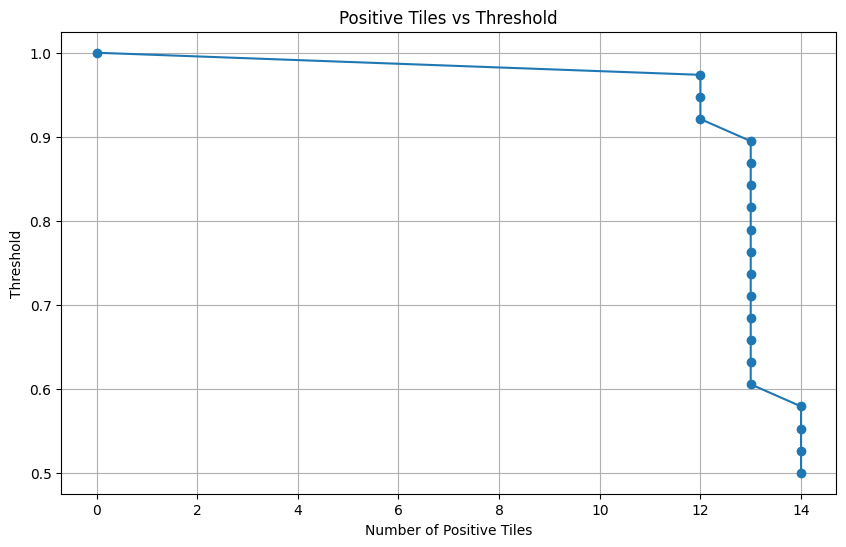

In [6]:
# display roc curve #
#####################

import matplotlib.pyplot as plt
import numpy as np

# Define a range of thresholds
thresholds = np.linspace(1, 0.5, num=20)  # 50 thresholds from 0 to 1

# Calculate positive tiles for each threshold
positiles_per_threshold = [sum(p > threshold for p in preds) for threshold in thresholds]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(positiles_per_threshold, thresholds, marker='o')
plt.ylabel('Threshold')
plt.xlabel('Number of Positive Tiles')
plt.title('Positive Tiles vs Threshold')
plt.grid(True)
plt.show()

Resolution level not found, using original size. Error:  tuple index out of range


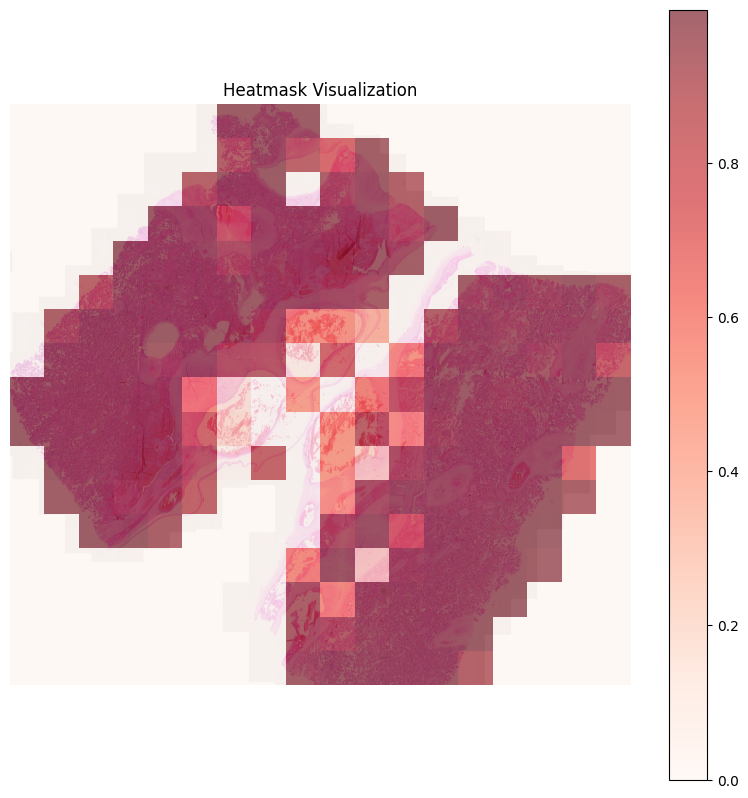

In [20]:
# display original wsi #
########################

try:
    resolution_level = 4   # 0 is the highest resolution, need to use the index of level_downsamples
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[resolution_level][1], pml_wsi.slide.slide.level_dimensions[resolution_level][0]),
        level=resolution_level
        )
    print("Working with pyramid resolution level", resolution_level, "shape:", region.shape[0:1])
except Exception as e:
    print("Resolution level not found, using original size. Error: ", e)
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0])
        )

def customTile():
    return Tile(region, coords=(0, 0), name="testregion", slide_type=types.HE)

tile = customTile()

from PIL import Image

plt.figure(figsize=(10, 10))
wsi_height, wsi_width = pml_wsi.shape
# extent = [0, wsi_width, wsi_height, 0] ??? also works 
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(region, extent=extent)
plt.imshow(heatmask, cmap='Reds', alpha=0.6, extent=extent, interpolation='nearest')
plt.colorbar()  # To show the color scale
plt.title('Heatmask Visualization')
plt.axis('off')  # Turn off the axis
plt.show()
